In [1]:
import os
import glob
import pandas as pd
import plotly as py
import cufflinks as cf
import re
%matplotlib inline

### Settings

In [2]:
# Path settings
base_path_to_csv = "/home/till/SharedFolder/trained_models/night-drive/weather_classifier/"

# Settings for epoch selection method
which_mode = "common"  # Options: ["manual", "common", "best_onemetric", "best_eachmetric"]
# epoch to use for mode "common" epoch
epoch_common = 40  # Options: [1, 40]
# metric to use for mode "best_onemetric"
onemetric = "accuracy"  # Options: ['f1_score_weighted', 'f1_score_micro', 'f1_score_macro', 'accuracy', 'roc_auc_micro', 'roc_auc_macro', 'pr_micro', 'pr_macro', 'mcc', 'train_loss', 'train_dev_loss']
# manual list of epochs for mode "manual"
list_selepochs = [[10, 10, 13, 10, 13, 10], # for each trial of run "without_cloudy"
                  [10, 10, 10, 10, 10, 10]] # for each trial of run "with_cloudy"

### Select classifier results

In [3]:
# load results and pick best epochs
# for each run and trial, these results contain a variety of metrics for all epochs for all sub-splits (train, valid, etc)
df_sel = pd.DataFrame()
df_sel_epochs = pd.DataFrame()
df_all = pd.DataFrame()
list_runs = ["without_cloudy", "with_cloudy"]
list_trials = ["train_A_over", "train_B_over", "train_C_over", "train_A_over_ganaug_025", "train_A_over_ganaug_050", "train_B_over_ganaug_025", "train_A_over_ganaug_050_augonlyasbase"]
for r, run in enumerate(list_runs):  # for each set of classifier runs
    for t, trial in enumerate(list_trials):  # for each data set
        path_to_csv = os.path.join(base_path_to_csv,run,trial)
        csv_files = glob.glob(path_to_csv + "/*.csv")
        ### Combine CSVs into one DataFrame ###
        df = pd.DataFrame()
        for csv_file in csv_files:
            df = pd.concat([df, pd.read_csv(csv_file)], axis = 0)
            df = df.reset_index(drop = True)
        ### Some preprocessing ###
        #
        df = df.drop(columns = ["weights"])
        #
        df.data = df.data.apply(lambda x: x.split(os.sep)[-1].split(".json")[0].split("bdd100k_sorted_")[-1])
        df = df.sort_values(by = ["data", "epoch"])
        df = df.reset_index(drop = True)
        ### Load training log file ###
        train_log_file = glob.glob(path_to_csv + "/*.txt")
        assert(len(train_log_file) == 1)
        df_loss = pd.read_csv(train_log_file[0], sep = " ", header = None, skiprows = [0, 1])
        df_loss = df_loss.iloc[:, [1, 3, 7, 11]].rename(columns = {1: "epoch", 3: "batch", 7: "train_loss", 11: "train_dev_loss"})
        df_loss.epoch = df_loss.epoch.apply(lambda x: int(x.split("/")[0]))
        df_loss.batch = df_loss.batch.apply(lambda x: int(x.split("/")[0]))
        df_loss["global_batch"] = (df_loss.epoch - 1) * df_loss.batch.max() + df_loss.batch
        df_loss = df_loss.sort_values(by = ["epoch", "batch"]).set_index("global_batch", drop = True)
        ### Combine loss, scores
        df_combined = df_loss.groupby(by = ["epoch"]).median()
        df_combined = df_combined.drop(columns = ["batch"])
        ### Combine loss, scores into metrics
        # df = df.join(df_combined, on="epoch")
        # stash best results according to selected method
        if which_mode in ["manual", "common"]:
            if which_mode == "manual":  # manual list of epochs, e.g. balancing overfitting and performance
                sel_epoch = list_selepochs[r][t]
            elif which_mode == "common":  # same epoch for every run
                sel_epoch = epoch_common
            rw = df.query("epoch==@sel_epoch").copy()
            rw.loc[:, "trial"] = list_trials[t]
            rw.loc[:, "run"] = list_runs[r]
            df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_onemetric":  # for each run, the best epoch accoding to one metric is selected 
            sel_epoch = []
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                rw = df_subsplit.loc[df_subsplit[onemetric].idxmax(), :].to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 
        elif which_mode == "best_eachmetric":  # all runs and metrics are evaluated independently on their best epoch 
            # find best epoch metric for each metric
            for subsplit in df.data.unique():
                df_subsplit = df.query("data == @subsplit").copy()
                df_subsplit.reset_index(drop=True, inplace=True)
                sel_epochs = df_subsplit.loc[:,df_subsplit.columns[df_subsplit.dtypes == "float64"]].idxmax().to_frame().T
                sel_epochs.loc[:, "trial"] = list_trials[t]
                sel_epochs.loc[:, "run"] = list_runs[r]
                rw = df_subsplit.max().to_frame().T
                rw.loc[:, "trial"] = list_trials[t]
                rw.loc[:, "run"] = list_runs[r]
                df_sel_epochs = df_sel_epochs.append(sel_epochs, ignore_index=True, sort=True) 
                df_sel = df_sel.append(rw, ignore_index=True, sort=True) 

        # stash all data
        df_all = pd.concat([df_all, df], axis=1)

In [4]:
df.head(5)

,epoch,data,f1_score_weighted,f1_score_micro,f1_score_macro,accuracy,accuracy_balanced,roc_auc_micro,roc_auc_macro,pr_micro,pr_macro,mcc
0,1,test,0.416610,0.357603,0.362211,0.357603,0.507598,0.558730,0.758074,0.418042,0.556142,0.217372
1,2,test,0.617604,0.548325,0.515300,0.548325,0.635635,0.775693,0.860508,0.653937,0.708613,0.354225
2,3,test,0.773570,0.740335,0.637989,0.740335,0.716836,0.897251,0.894623,0.825988,0.769045,0.483436
3,4,test,0.813300,0.795103,0.678030,0.795103,0.735718,0.926422,0.905948,0.873937,0.792658,0.536706
4,5,test,0.811756,0.793814,0.676484,0.793814,0.736812,0.929515,0.910921,0.878833,0.803043,0.535187


In [5]:
df_sel.head(5)

,accuracy,accuracy_balanced,data,epoch,f1_score_macro,f1_score_micro,f1_score_weighted,mcc,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro,run,trial
0,0.893041,NaN,test,40,0.791867,0.893041,0.892044,NaN,0.849390,0.945574,0.929549,0.968840,without_cloudy,train_A_over
1,0.930233,NaN,test_daytime,40,0.898486,0.930233,0.930539,NaN,0.956918,0.980116,0.986176,0.988961,without_cloudy,train_A_over
2,0.869474,NaN,test_night,40,0.663411,0.869474,0.866014,NaN,0.686719,0.913453,0.845422,0.951900,without_cloudy,train_A_over
3,0.908545,NaN,train_dev_A_over,40,0.908601,0.908545,0.908599,NaN,0.967581,0.966268,0.982222,0.980927,without_cloudy,train_A_over
4,0.889820,NaN,valid,40,0.783580,0.889820,0.889450,NaN,0.852354,0.950236,0.936420,0.971064,without_cloudy,train_A_over


In [6]:
# print best epochs for each metric, if available
if which_mode == "best_eachmetric":
    print(df_sel_epochs.head(12))

### Print results for best epochs gouped by split

In [7]:
# Selection (and order) of columns to be printed
meta2print = ["epoch", "trial", "run"]
metrics2print = ['accuracy','f1_score_macro', 'f1_score_micro', 'f1_score_weighted', 'pr_macro', 'pr_micro', 'roc_auc_macro', 'roc_auc_micro']
cols2print = [*meta2print, *metrics2print]
# rename train dev sets
df_sel.data = df_sel.data.apply(lambda x: re.sub(r"_[A-C]_[a-zA-Z0-9_]*", r"", x))

#### Valid-All

In [8]:
split = "valid"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "=== Results for best manual epoch ===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid === Results for best manual epoch ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.889820,0.783580,0.889820,0.889450,0.852354,0.950236,0.936420,0.971064
1,40,train_B_over,without_cloudy,0.886598,0.792895,0.886598,0.889747,0.881026,0.953139,0.954105,0.973337
2,40,train_C_over,without_cloudy,0.885309,0.790260,0.885309,0.888790,0.864707,0.946349,0.950298,0.969590
3,40,train_A_over_ganaug_025,without_cloudy,0.882732,0.779181,0.882732,0.884311,0.856611,0.947808,0.941107,0.970216
4,40,train_A_over_ganaug_050,without_cloudy,0.877577,0.778588,0.877577,0.881690,0.853329,0.940512,0.941699,0.965437
5,40,train_B_over_ganaug_025,without_cloudy,0.909149,0.822871,0.909149,0.908971,0.882712,0.961221,0.953382,0.977627
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.898196,0.790524,0.898196,0.895700,0.850054,0.955286,0.940357,0.974108
7,40,train_A_over,with_cloudy,0.822500,0.738252,0.822500,0.822823,0.804790,0.882307,0.926545,0.952088
8,40,train_B_over,with_cloudy,0.829500,0.765341,0.829500,0.830894,0.836391,0.893457,0.938327,0.956270
9,40,train_C_over,with_cloudy,0.825500,0.758048,0.825500,0.827340,0.830144,0.892775,0.938936,0.956315


#### Valid-Night

In [9]:
split = "valid_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== valid_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.872632,0.677948,0.872632,0.871957,0.712128,0.924982,0.867870,0.956553
1,40,train_B_over,without_cloudy,0.869474,0.711523,0.869474,0.875541,0.791588,0.931796,0.911591,0.961416
2,40,train_C_over,without_cloudy,0.865263,0.717173,0.865263,0.873756,0.797764,0.924146,0.917653,0.957276
3,40,train_A_over_ganaug_025,without_cloudy,0.867368,0.681170,0.867368,0.868530,0.725998,0.923877,0.881512,0.957387
4,40,train_A_over_ganaug_050,without_cloudy,0.852632,0.682168,0.852632,0.860794,0.736310,0.913558,0.886798,0.949857
5,40,train_B_over_ganaug_025,without_cloudy,0.901053,0.746900,0.901053,0.898420,0.799628,0.948645,0.911384,0.970728
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.883158,0.674838,0.883158,0.875063,0.706784,0.935420,0.875273,0.962480
7,40,train_A_over,with_cloudy,0.829000,0.611683,0.829000,0.825891,0.632412,0.866353,0.839313,0.942095
8,40,train_B_over,with_cloudy,0.860000,0.700336,0.860000,0.860600,0.738884,0.900863,0.885558,0.957341
9,40,train_C_over,with_cloudy,0.844000,0.680184,0.844000,0.847903,0.736690,0.897807,0.893156,0.956999


In [10]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== valid_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,train_B_over,without_cloudy,-0.003158,0.033575,-0.003158,0.003583,0.079461,0.006814,0.043721,0.004862
2,0,train_C_over,without_cloudy,-0.007368,0.039225,-0.007368,0.001799,0.085637,-0.000835,0.049783,0.000723
3,0,train_A_over_ganaug_025,without_cloudy,-0.005263,0.003222,-0.005263,-0.003427,0.013870,-0.001105,0.013642,0.000833
4,0,train_A_over_ganaug_050,without_cloudy,-0.020000,0.004220,-0.020000,-0.011163,0.024183,-0.011424,0.018928,-0.006697
5,0,train_B_over_ganaug_025,without_cloudy,0.028421,0.068952,0.028421,0.026463,0.087501,0.023663,0.043514,0.014175
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.010526,-0.003109,0.010526,0.003106,-0.005343,0.010439,0.007403,0.005926
7,0,train_A_over,with_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,train_B_over,with_cloudy,0.031000,0.088652,0.031000,0.034709,0.106472,0.034510,0.046246,0.015246
9,0,train_C_over,with_cloudy,0.015000,0.068501,0.015000,0.022012,0.104279,0.031454,0.053843,0.014904


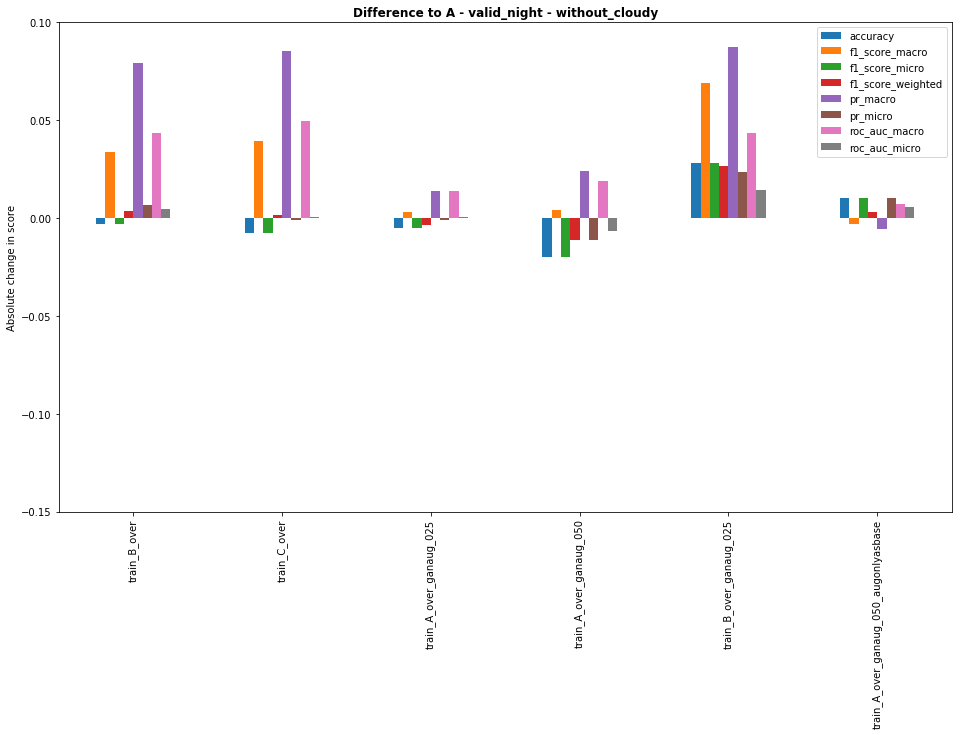

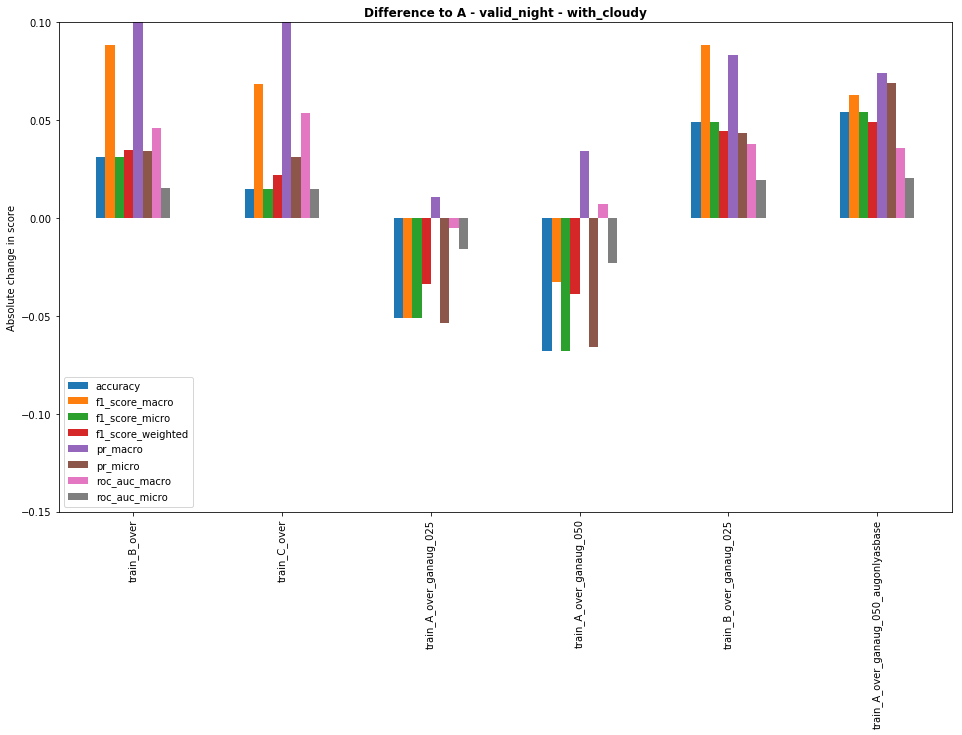

In [11]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")

#### Test-All

In [12]:
split = "test"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.893041,0.791867,0.893041,0.892044,0.849390,0.945574,0.929549,0.968840
1,40,train_B_over,without_cloudy,0.893686,0.811577,0.893686,0.896373,0.881034,0.948017,0.943386,0.971062
2,40,train_C_over,without_cloudy,0.888531,0.799317,0.888531,0.892048,0.876282,0.945521,0.945515,0.969768
3,40,train_A_over_ganaug_025,without_cloudy,0.874356,0.766362,0.874356,0.876185,0.845613,0.943292,0.934093,0.966973
4,40,train_A_over_ganaug_050,without_cloudy,0.872423,0.773689,0.872423,0.876975,0.848532,0.935187,0.932805,0.962689
5,40,train_B_over_ganaug_025,without_cloudy,0.907216,0.814890,0.907216,0.906498,0.873301,0.954556,0.944380,0.974002
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.894330,0.789699,0.894330,0.892296,0.843960,0.946365,0.928996,0.969666
7,40,train_A_over,with_cloudy,0.842500,0.769192,0.842500,0.842002,0.827548,0.896343,0.928833,0.957352
8,40,train_B_over,with_cloudy,0.845500,0.783595,0.845500,0.847093,0.844906,0.894831,0.941317,0.959036
9,40,train_C_over,with_cloudy,0.849500,0.784015,0.849500,0.850207,0.845498,0.901672,0.942846,0.960884


#### Test-Night

In [13]:
split = "test_night"
df_cursplit = df_sel.query("data==@split").copy()
df_cursplit.reset_index(drop=True, inplace=True)
print("\n===", split, "===")
df_cursplit.loc[:, cols2print].head(df_cursplit.shape[0])


=== test_night ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,40,train_A_over,without_cloudy,0.869474,0.663411,0.869474,0.866014,0.686719,0.913453,0.845422,0.951900
1,40,train_B_over,without_cloudy,0.872632,0.726097,0.872632,0.878429,0.784759,0.918725,0.888770,0.956871
2,40,train_C_over,without_cloudy,0.863158,0.700694,0.863158,0.870917,0.785979,0.912585,0.891864,0.953393
3,40,train_A_over_ganaug_025,without_cloudy,0.843158,0.635367,0.843158,0.846696,0.696527,0.914633,0.866091,0.951022
4,40,train_A_over_ganaug_050,without_cloudy,0.843158,0.663023,0.843158,0.852438,0.715014,0.898848,0.866074,0.943350
5,40,train_B_over_ganaug_025,without_cloudy,0.901053,0.742339,0.901053,0.898670,0.779434,0.936863,0.890424,0.965084
6,40,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.872632,0.652387,0.872632,0.865285,0.673306,0.914852,0.847949,0.954091
7,40,train_A_over,with_cloudy,0.851000,0.649404,0.851000,0.844845,0.674098,0.882963,0.846767,0.949371
8,40,train_B_over,with_cloudy,0.854000,0.666722,0.854000,0.851642,0.739498,0.885350,0.889316,0.954951
9,40,train_C_over,with_cloudy,0.858000,0.659759,0.858000,0.853619,0.743259,0.894478,0.886673,0.957056


In [14]:
print("\n===", split, "Difference to A ===")
one_half = df_cursplit.shape[0]//2
df_cursplit_diff = df_cursplit.copy()
for col in df_cursplit.columns:
    if not isinstance(df_cursplit.loc[0,col], str):
        df_cursplit_diff.loc[0:one_half-1,col] = df_cursplit_diff.loc[0:one_half-1,col] - df_cursplit.loc[0,col]
        df_cursplit_diff.loc[one_half:one_half*2-1,col] = df_cursplit_diff.loc[one_half:one_half*2-1,col] - df_cursplit.loc[one_half,col]
df_cursplit_diff.loc[:, cols2print].head(df_cursplit_diff.shape[0])


=== test_night Difference to A ===


,epoch,trial,run,accuracy,f1_score_macro,f1_score_micro,f1_score_weighted,pr_macro,pr_micro,roc_auc_macro,roc_auc_micro
0,0,train_A_over,without_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,train_B_over,without_cloudy,0.003158,0.062686,0.003158,0.012415,0.098040,0.005273,0.043348,0.004971
2,0,train_C_over,without_cloudy,-0.006316,0.037284,-0.006316,0.004903,0.099260,-0.000867,0.046442,0.001492
3,0,train_A_over_ganaug_025,without_cloudy,-0.026316,-0.028044,-0.026316,-0.019318,0.009808,0.001181,0.020670,-0.000879
4,0,train_A_over_ganaug_050,without_cloudy,-0.026316,-0.000387,-0.026316,-0.013576,0.028295,-0.014605,0.020653,-0.008551
5,0,train_B_over_ganaug_025,without_cloudy,0.031579,0.078928,0.031579,0.032656,0.092715,0.023410,0.045002,0.013183
6,0,train_A_over_ganaug_050_augonlyasbase,without_cloudy,0.003158,-0.011024,0.003158,-0.000729,-0.013413,0.001399,0.002527,0.002191
7,0,train_A_over,with_cloudy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0,train_B_over,with_cloudy,0.003000,0.017318,0.003000,0.006797,0.065400,0.002387,0.042548,0.005580
9,0,train_C_over,with_cloudy,0.007000,0.010355,0.007000,0.008774,0.069161,0.011516,0.039906,0.007685


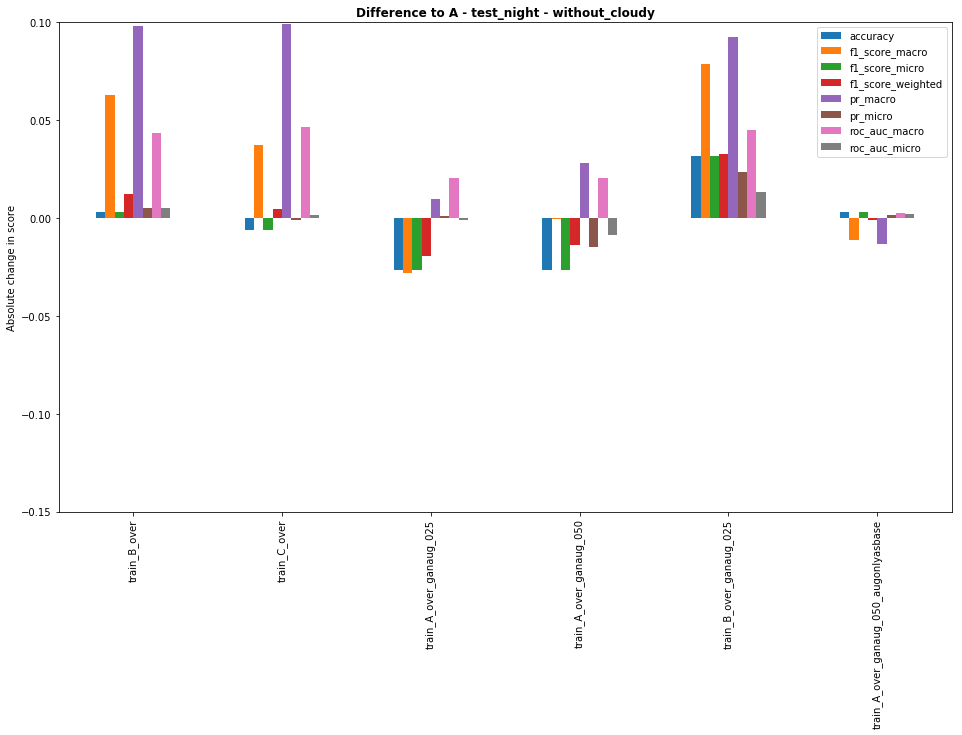

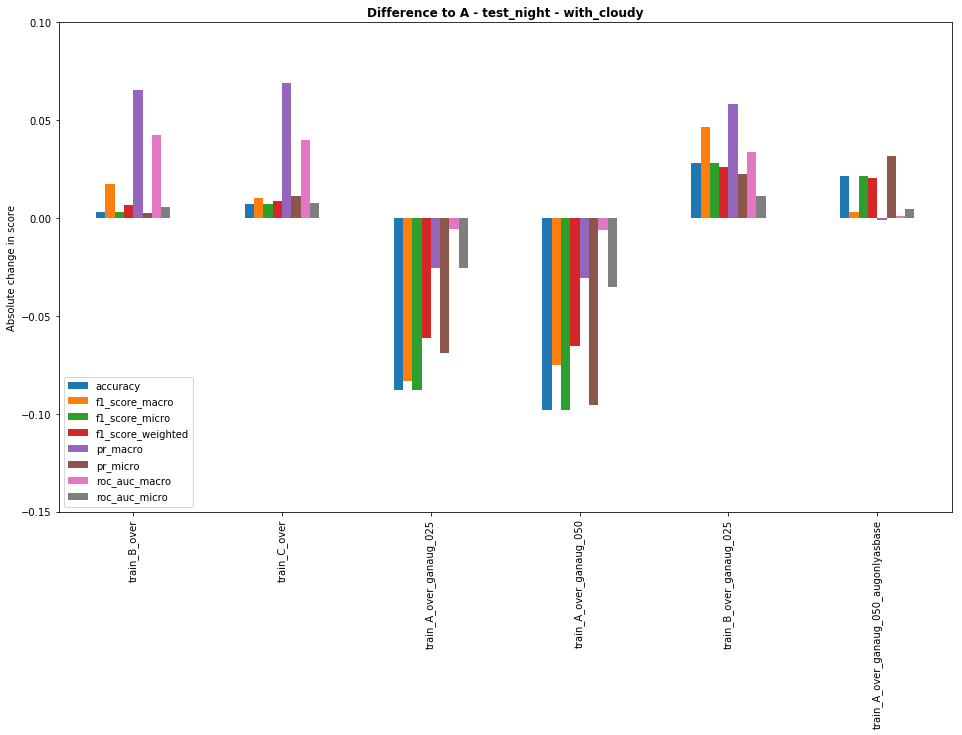

In [15]:
# plot difference
for trial in ["without_cloudy", "with_cloudy"]:
    df_cursplit_plot = df_cursplit_diff.copy()
    df_cursplit_plot = df_cursplit_plot.loc[df_cursplit_diff.run==trial, :].reset_index(drop=True)
    df_cursplit_plot = df_cursplit_plot.loc[1:df_cursplit_plot.shape[0], :]
    ax = df_cursplit_plot.set_index(["trial"]).loc[:, metrics2print].plot(kind = "bar", figsize = (16, 9))
    ax.set_xlabel("")
    ax.set_ylabel("Absolute change in score")
    ax.set_ylim(-0.15, 0.1)
    ax.set_title(f"Difference to A - {split} - {trial}", fontweight="bold")